# Hillslope Integrated Hydrology + Reactive Transport

## Mesh

The hillslope domain is 1000 meters long, 45 meters thick with slope of 0.1.


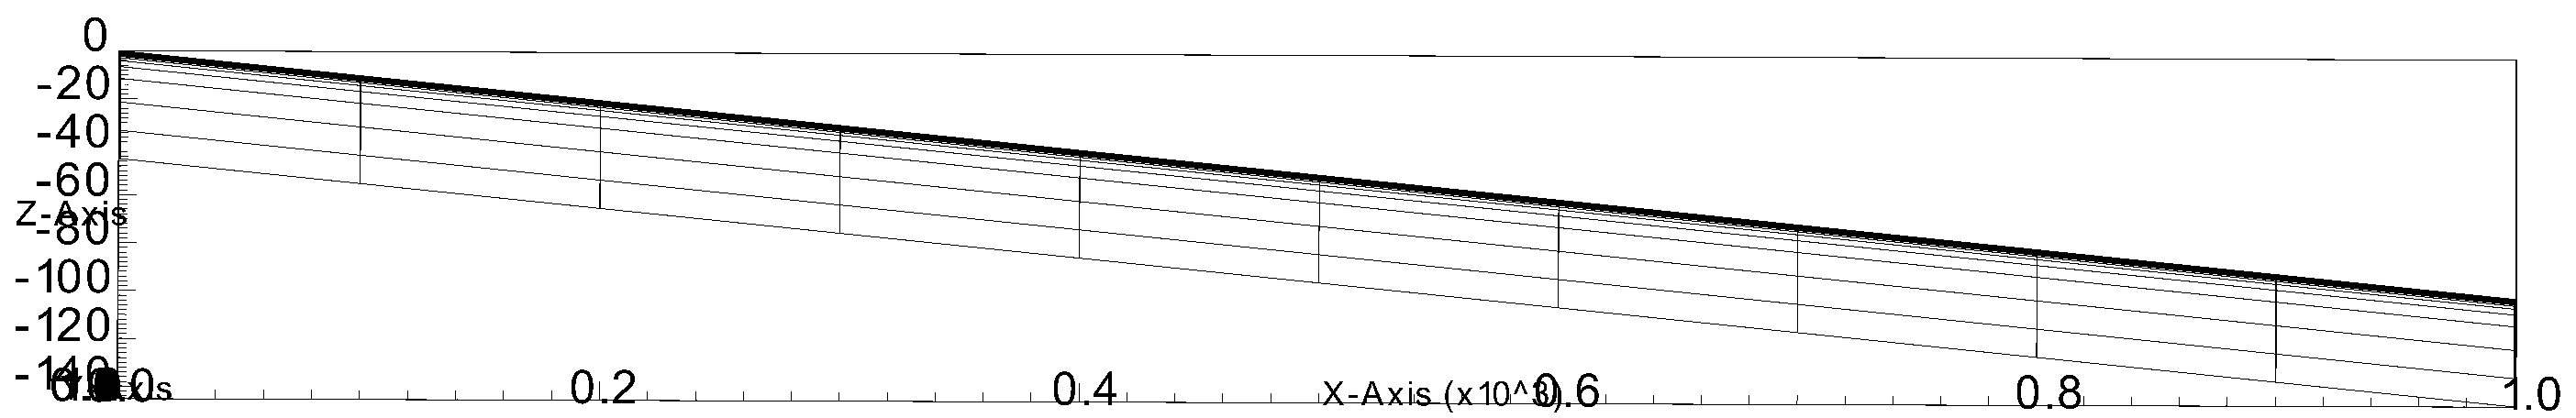

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
from IPython.display import Image

## Integrated Hydrology

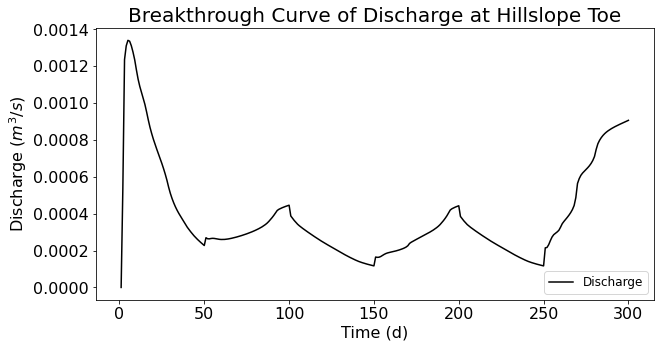

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]
path='./'
DISCHARGE = np.loadtxt(path+'surface_outlet_flux.dat', skiprows=12) 

plt.plot(DISCHARGE[:,0]/86400, DISCHARGE[:,1]*0.000018, 'k-', label='Discharge')
plt.title("Breakthrough Curve of Discharge at Hillslope Toe", fontsize=20)
plt.xlabel("Time (d)",fontsize=16)
plt.ylabel("Discharge ($m^3/s$)",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12, loc='lower right')
plt.show()

## Reactive Transport

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]
path='./'
BTC_1 = np.loadtxt(path+'surface_total_concentration.dat', skiprows=12) 
FREE_1 = np.loadtxt(path+'surface_free_ion_species.dat', skiprows=12) 

In [4]:
rate = 55.55*10**6 

/Users/zexuanxu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


Text(0.5, 1.0, 'Breakthrough Curves of Concentrations')

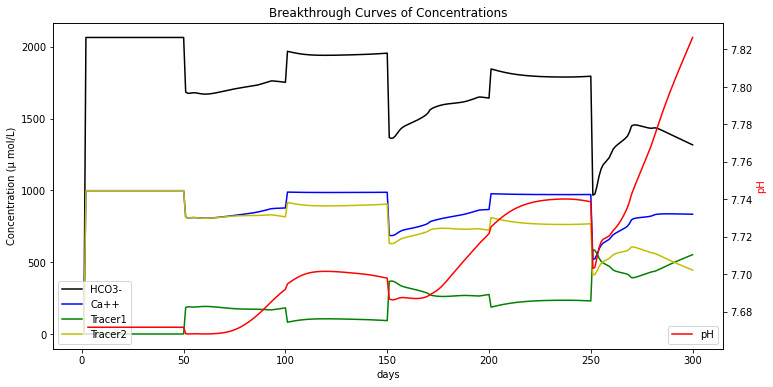

In [5]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(111)
ax1.set_xlabel('days')
ax1.set_ylabel('Concentration (\u03BC mol/L)', color='k')
ax1.plot(BTC_1[:,0]/86400, BTC_1[:,2]*rate, 'k-', BTC_1[:,0]/86400, BTC_1[:,3]*rate, 'b-', BTC_1[:,0]/86400, BTC_1[:,4]*rate, 'g-', BTC_1[:,0]/86400, BTC_1[:,5]*rate, 'y-')
ax1.tick_params(axis='y', labelcolor='k')
# ax1.set_ylim((600, 1000))
ax1.legend(['HCO3-','Ca++','Tracer1','Tracer2'], loc='lower left')

ax2 = ax1.twinx()
ax2.plot(BTC_1[:,0]/86400, -np.log10(FREE_1[:,1]), 'r')
ax2.set_ylabel('pH', color='r')
ax2.legend(['pH'], loc='lower right')

ax1.set_title('Breakthrough Curves of Concentrations')
# ax2.set_ylim((0, 10))
# ax2.set_ylim(ax2.get_ylim()[::-1])